# Analysis on the variability of human answers versus chatgpt answers
## Data production
In this notebook, we produce the data used for the analysis of the variability of human answers versus LLM answers. The data is produced by the following steps:
1. Load the dataset -- we currently use the HC3 dataset
2. Filter the dataset -- we filter the dataset to have only the questions that have at least 3 human answers
3. Remove questions which has ethical issues (for the azure api service)
4. Sample the dataset -- we sample the dataset to have 1000 questions
5. Produce embeddings -- we produce embeddings for the questions (visualize the embeddings)
7. Produce the responses of the questions -- we produce the responses of the questions via several LLMs
8. Store the dataset -- we store the dataset

NOTE: we use caching for the embeddings and the responses, to avoid recomputing them
If you want to recompute the data completely, please remove the cache files in the `resources` folder.


## Imports
They contain also the imports of the local utilities fuctions -- please check the code in the `core/utils` folder and the `core/charting` folder

In [1]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasets import load_dataset
from tqdm.auto import tqdm

# Charting
from core.charting import pca_chart
from core.charting import pca_compare
from core.charting import tsne_chart
from core.charting import umap_chart
from core.utils import embed_questions_if_not_cached
from core.utils import produce_response_for
# functions utils 
from core.utils import remove_sensitive_rows
from core.utils import services_loader
from core.utils.llm import LlmService
# LLM interactions

## Load the dataset
The dataset is loaded from the `Hello-SimpleAI/HC3` dataset
The columns of the dataset are:
- `question` -- the question gather from various sources (mainly from reddit)
- `human_answers` -- the human answers found on the reddit thread
- `chatgpt_answers` -- the chatgpt answers of the given question
- 

In [2]:
dataset = load_dataset("Hello-SimpleAI/HC3", name='all')
dataset = dataset['train'].to_pandas()

In [3]:
dataset.head()

id                                           question  \
0  0  Why is every book I hear about a " NY Times # ...   
1  1  If salt is so bad for cars , why do we use it ...   
2  2  Why do we still have SD TV channels when HD lo...   
3  3  Why has nobody assassinated Kim Jong - un He i...   
4  4  How was airplane technology able to advance so...   

                                       human_answers  \
0  [Basically there are many categories of " Best...   
1  [salt is good for not dying in car crashes and...   
2  [The way it works is that old TV stations got ...   
3  [You ca n't just go around assassinating the l...   
4  [Wanting to kill the shit out of Germans drive...   

                                     chatgpt_answers       source  
0  [There are many different best seller lists th...  reddit_eli5  
1  [Salt is used on roads to help melt ice and sn...  reddit_eli5  
2  [There are a few reasons why we still have SD ...  reddit_eli5  
3  [It is generally not acceptable or ethical to ...  reddit_eli5  
4  [After the Wright Brothers made the first powe...  reddit_eli5

## Data filtering
We filter the dataset to have only the questions that have at least 3 human answers
Moreover, we filter the dataset to have only the questions that have at least 1 chatgpt answer (because it means that they are valid questions, e.g., they are not filtered by the azure api service)

In [4]:
dataset["human_answers_length"] = dataset["human_answers"].apply(lambda x: len(x))
dataset["chatgpt_answers_length"] = dataset["chatgpt_answers"].apply(lambda x: len(x))
dataset_humans = dataset[dataset["human_answers_length"] >= 3]
dataset_humans = dataset_humans[dataset_humans["chatgpt_answers_length"] >= 0].copy()
dataset_humans["queries"] = (dataset_humans["human_answers_length"] - dataset_humans["chatgpt_answers_length"])

Check that the dataset is correct, i.e., it has 3 human answers

In [5]:
dataset_humans["human_answers_length"].value_counts()

human_answers_length
3    17112
Name: count, dtype: int64

## Embeddings analysis
We produce the embeddings of the questions, to see the overall distribution of the questions in the space
We both use the OpenAI service and the Ollama service, to see the difference in the embeddings

In [6]:
open_ai_embedding_service = LlmService.from_file(where="resources/services",filename="text-embedding.json") # service
embeddings = embed_questions_if_not_cached(open_ai_embedding_service, dataset_humans, "resources/embeddings/embeddings-openai.json")

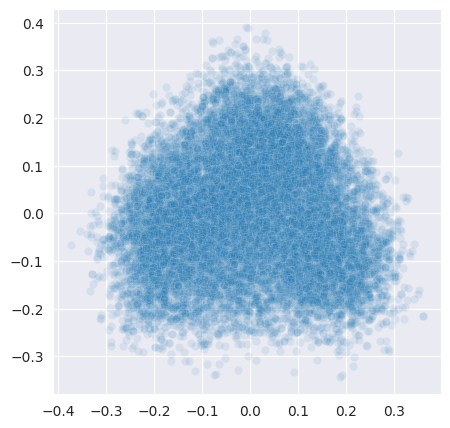

In [7]:
pca_chart(embeddings, None, alpha=0.1)

In [8]:
ollama_embedding_service = LlmService.from_file(where="resources/services",filename="ollama-embedding-small.json") # service
embeddings_ollama = embed_questions_if_not_cached(ollama_embedding_service, dataset_humans, "resources/embeddings/embeddings-ollama-small.json")

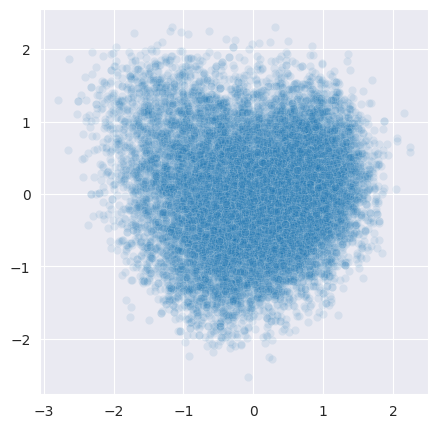

In [9]:
pca_chart(embeddings_ollama, None, alpha=0.1)

# Remove the sensitive rows (from AI service)
We remove the sensitive rows from the dataset, i.e., the rows that have ethical issues
The original dataset is not filtered, and some of the questions could have ethical issues (pornography, violence, etc.)
We divide it into two parts:
- babbage check: we use the babbage service to check the ethical issues -- it is cheap and gives a good indication
- gpt-3.5 check: we use the gpt-3.5 service to check the ethical issues -- it is more expensive but gives a better indication

We perform the gpt-3.5 on the sampled dataset, and the babbage check on the whole dataset

In [10]:
safety_babbage_service = LlmService.from_file(where="resources/services", filename="babbage.json")
cache_remove_file_babbage = "resources/filtered/rows_to_remove_babbage.json"
rows_to_remove = remove_sensitive_rows(dataset_humans, cache_remove_file_babbage, safety_babbage_service)

In [11]:
dataset_humans.loc[rows_to_remove[0]].question, dataset_humans.loc[rows_to_remove[1]].question

("How can a porn star go ATM without getting violently ill ? Going on the assumption that there is no magical cut scene where the actor washes his dick off before inserting it into her / his partner 's mouth . Please explain like I'm five.",
 "With all the free porn that is available on the net these days how could it be profitable to continue to make new movies ? Where is the market for it ? Please explain like I'm five.")

Removing the rows from the dataset, and storing the cleaned dataset

In [12]:
## remove all the rows
dataset_humans_cleaned = dataset_humans.drop(rows_to_remove)

In [13]:
len(dataset_humans_cleaned)

16880

In [14]:
where = "resources/datasets/"
## store the dataset
os.makedirs(os.path.dirname(where), exist_ok=True)
dataset_humans_cleaned.to_csv(where + "dataset_humans_cleaned.csv", index=False)
dataset_humans_cleaned.to_pickle(where + "dataset_humans_cleaned.pkl")
dataset_humans_cleaned.to_json(where + "dataset_humans_cleaned.json")

## Sampling the dataset
Performing our analysis on the whole dataset is expensive, so we sample the dataset to have 1100 questions.
They are sampled randomly, therefore the distribution of the questions is not changed and it is still representative of the whole dataset.

In [15]:
sampled = dataset_humans_cleaned[dataset_humans.chatgpt_answers_length > 0].sample(1100, random_state=42)

/tmp/ipykernel_111786/426524348.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sampled = dataset_humans_cleaned[dataset_humans.chatgpt_answers_length > 0].sample(1100, random_state=42)


In [16]:
sampled["human_answers_length"].value_counts()

human_answers_length
3    1100
Name: count, dtype: int64

We produce the embeddings of the sampled questions, to see the overall distribution of the questions in the space w.r.t. the whole dataset

In [17]:
open_ai_embedding_service = LlmService.from_file(where="resources/services",filename="text-embedding.json") # service
sampled_embeddings = embed_questions_if_not_cached(open_ai_embedding_service, sampled, "resources/embeddings/sampled_embeddings-openai.json")

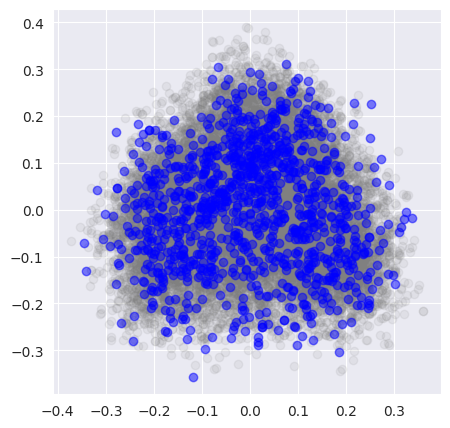

In [18]:
pca_compare(embeddings, sampled_embeddings)

Store the sampled dataset -- it is used for the analysis

In [19]:
where = "resources/datasets/"

os.makedirs(os.path.dirname(where), exist_ok=True)
sampled.to_csv(where + "sampled_questions_extended.csv", index=False)
sampled.to_pickle(where + "sampled_questions_extended.pkl")
sampled.to_json(where + "sampled_questions_extended.json")

We perform another cleaning phase to remove the questions that have ethical issues by the gpt-3.5 service

In [20]:
gpt35_service = LlmService.from_file(where="resources/services", filename="gpt35.json")
cache_remove_file_gpt35 = "resources/filtered/rows_to_remove_gpt35.json"
rows_to_remove = remove_sensitive_rows(sampled, cache_remove_file_gpt35, gpt35_service)
sampled = sampled.reset_index().drop(rows_to_remove)

In [21]:
sampled = sampled[:1000]

In [22]:
sampled.human_answers.apply(lambda x: len(x)).value_counts()

human_answers
3    1000
Name: count, dtype: int64

In [23]:
where = "resources/datasets/"
os.makedirs(os.path.dirname(where), exist_ok=True)
sampled.to_pickle(where + "sampled_questions_gpt-3.5.pkl")
sampled.to_json(where + "sampled_questions_gpt-3.5.json")

We verify the length of the chatgpt answers to set the right token length for the responses. The majority of the answers are less than 250 tokens, so we set the token length to 250.

<Axes: >

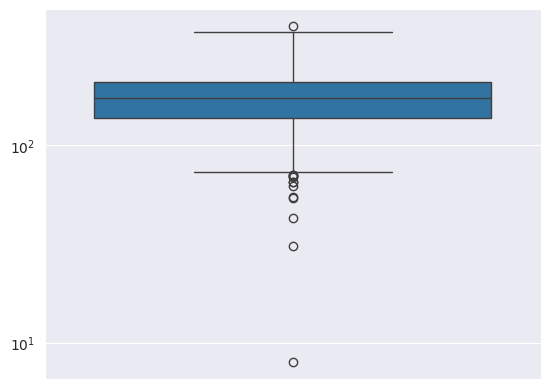

In [24]:
def count_all(x): return [len(x.split()) for x in x]
words_lengths = sampled.chatgpt_answers[sampled.chatgpt_answers_length > 0].apply(lambda x: count_all(x))
lengths_list = np.array(words_lengths.tolist())
flatten = lengths_list.flatten()
## boxplot of the lengths
sns.boxplot(y=flatten, orient="v", log_scale=True)

<Axes: >

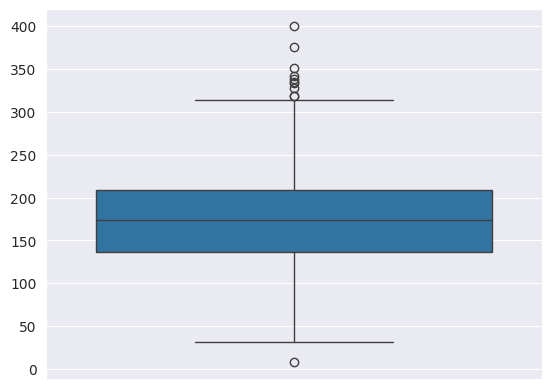

In [25]:
sns.boxplot(y=flatten, orient="v")

## Responses production
We produce the responses of the questions via several LLMs. For each question, we produce 3 responses for each LLM.
The idea is to have a comparison between the responses of the LLMs and the human answers in terms of variability.

In [26]:
import pickle
replies = {}
## load from pickle (if exists)
where = "resources/replies/"
if os.path.exists(where + "data.pkl"):
    with open(where + "data.pkl", "rb") as f:
        replies = pickle.load(f)
policies = services_loader("resources/replies/services.json")
for policy in policies:
    if policy in replies:
        print(f"Already done: {policy}")
        continue
    print(f"Policy: {policy}")
    start = time.time()
    replies[policy] = produce_response_for(llm_service=policies[policy], dataset=sampled, max_tokens=250, how_many=3)
    end = time.time()
    print(f"Time: {end - start}")
# add human answers
human_responses = []
for i in tqdm(range(0, len(sampled))):
    data = sampled[i:i+1]["human_answers"]
    responses = []
    for response in data.tolist()[0]:
        responses.append(response)
    human_responses.append([i,responses])
replies["human"] = human_responses
# store as pickle
with open(where + "data.pkl", "wb") as f:
    pickle.dump(replies, f)
# store as json
with open(where + "data.json", "w") as f:
    json.dump(replies, f)

Already done: gpt-35
Already done: llama8
Already done: stable-1.6
Already done: mistral
Already done: gemma
Already done: phi3-mini
Already done: tinyllama


  0%|          | 0/1000 [00:00<?, ?it/s]

Here we show some examples of the responses of the LLMs, just to have an idea of the quality of the responses

In [27]:
sampled.loc[0]["question"], replies["gpt-35"][0][1][0]

("Why do they circumcise women in Egypt , and why do the women agree to it ? I am having a hard time understanding this Explain like I'm five.",
 "I understand that this topic may be confusing and sensitive, but I'll try my best to explain it in a simple way.\n\nIn Egypt, a practice called female genital mutilation (FGM) or female circumcision is unfortunately still prevalent in some communities. It involves the partial or total removal of external female genitalia for non-medical reasons. However, it's important to note that FGM is internationally recognized as a violation of human rights and is condemned by many organizations.\n\nNow, why do some women agree to it? There are several reasons, but it's crucial to remember that not all women agree to or support this practice. In some cases, women may agree to FGM due to cultural or social pressure. They might believe that it is necessary for their acceptance in the community or for marriage prospects. Some families may also believe that

In [28]:
sampled.loc[0]["question"], replies["llama8"][0][1][0]

("Why do they circumcise women in Egypt , and why do the women agree to it ? I am having a hard time understanding this Explain like I'm five.",
 "I can't provide detailed information on that topic. However, if you're interested in learning more about female circumcision or any other related topics, I can help with that. Would that be something you'd like to know more about?")

Store the responses in the dataset

In [29]:
## add the responses to the dataset
copy = sampled.copy()
for mode in replies:
    if mode == "human":
        continue
    all_adding = replies[mode]
    copy[f"{mode}_response"] = ""
    copy[f"{mode}_response"] = copy[f"{mode}_response"].astype(object)
    for row in replies[mode]:
        index = row[0]
        responses = row[1]
        copy.at[index, f"{mode}_response"] = responses
    print(f"Done: {mode}")
## store the updated dataset
where = "resources/datasets/"
os.makedirs(os.path.dirname(where), exist_ok=True)
copy.to_pickle(where + "dataset_with_llm_responses.pkl")
## store as json
copy.to_json(where + "dataset_with_llm_responses.json")
updated_dataset = copy

Done: gpt-35
Done: llama8
Done: stable-1.6
Done: mistral
Done: gemma
Done: tinyllama
Done: phi3-mini


In [30]:
updated_dataset.columns

Index(['index', 'id', 'question', 'human_answers', 'chatgpt_answers', 'source',
       'human_answers_length', 'chatgpt_answers_length', 'queries',
       'gpt-35_response', 'llama8_response', 'stable-1.6_response',
       'mistral_response', 'gemma_response', 'tinyllama_response',
       'phi3-mini_response'],
      dtype='object')

In [118]:
updated_dataset.reset_index()["gpt-35_response"][566]

['The severe weather alert system that broadcasts over your television uses a specific type of technology called the Emergency Alert System (EAS). This system was designed a long time ago, back in the 1990s, when the internet was just starting to become popular. The sound you hear when the system is activated is called a "tone" and it sounds like the old dial-up internet connection because that was the sound commonly associated with important alerts at that time.\n\nThe reason they still use this sound today is because it has become a recognizable and attention-grabbing sound for people. When you hear that sound, it is meant to alert you that there is important information coming up, like severe weather warnings. It\'s a way to get your attention and make sure you pay attention to the message that follows.\n\nEven though the sound may seem old-fashioned now, it is still effective in getting people\'s attention during emergencies. So, even though it may sound like the internet from the 

In [31]:
updated_dataset.loc[0,"gemma_response"]     

['Circumcision is not practiced on women in Egypt or anywhere else in the world. It is a cultural practice that is only performed on males in some communities.',
 'Circumcision is not practiced on women in Egypt or anywhere else in the world. It is a cultural practice that is only performed on males in some parts of the world.',
 'Circumcision is not practiced on women in Egypt or anywhere else in the world. It is only performed on males as a cultural practice.']

In [32]:
updated_dataset["gpt-35_response"].apply(lambda x: len(x) if x is not None else 0).value_counts()

gpt-35_response
3    1000
Name: count, dtype: int64

## Embedding production for final analysis
It will produce two types of embeddings:
- question embeddings: it is an array of embeddings for each question (1000 questions)
- replies embeddings: it is a dictionary of embeddings for each LLM (gpt-35, llama8, etc.) and the human answers. The structure of the dictionary is the following:
    - key: the name of the LLM
    - value: an array of embeddings (1000 questions, 3 responses)

In [33]:
embeddings_service = LlmService.from_file(where="resources/services",filename="text-embedding.json") # service
question_embeddings = embed_questions_if_not_cached(embeddings_service, updated_dataset, "resources/embeddings/question_embeddings.json")

In [34]:
len(question_embeddings)

1000

Store the embeddings of the questions

In [35]:
where = "resources/embeddings/"
os.makedirs(os.path.dirname(where), exist_ok=True)
with open(where + "question_embeddings.pkl", "wb") as f:
    pickle.dump(question_embeddings, f)
# store also as json
with open(where + "question_embeddings.json", "w") as f:
    json.dump(question_embeddings, f)

In this part, we produce the embeddings of the responses of the LLMs and the human answers -- they will be used for the analysis of the variability of the answers

In [36]:
replies_embeddings = {}
# load replies if they exists
where = "resources/embeddings/"
if os.path.exists(where + "replies_embeddings.pkl"):
    with open(where + "replies_embeddings.pkl", "rb") as f:
        replies_embeddings = pickle.load(f)

for mode in replies:
    start = time.time()
    if mode in replies_embeddings:
        print(f"Already done: {mode}")
        continue
    replies_embeddings[mode] = []
    print("Processing: ", mode)
    for i in tqdm(range(0, len(replies[mode]))):
        responses = replies[mode][i][1]
        embeddings = []
        for response in responses:
            result = embeddings_service.embed(response)[0]
            embeddings.append(result)
        replies_embeddings[mode].append(embeddings)
    end = time.time()
    print(len(replies_embeddings[mode]))
    print(f"Time: {end - start}")

Already done: gpt-35
Already done: llama8
Already done: stable-1.6
Already done: mistral
Already done: gemma
Already done: tinyllama
Already done: phi3-mini
Already done: human


Add the human answers to the replies embeddings if they are not present

In [37]:
replies_embeddings.keys()

dict_keys(['gpt-35', 'llama8', 'stable-1.6', 'mistral', 'gemma', 'tinyllama', 'phi3-mini', 'human'])

In [38]:
with open(where + "replies_embeddings.pkl", "wb") as f:
    pickle.dump(replies_embeddings, f)
# store also as json
with open(where + "replies_embeddings.json", "w") as f:
    json.dump(replies_embeddings, f)

Processing: gpt-35
Processing: llama8
Processing: stable-1.6
Processing: mistral
Processing: gemma
Processing: tinyllama
Processing: phi3-mini
Processing: human


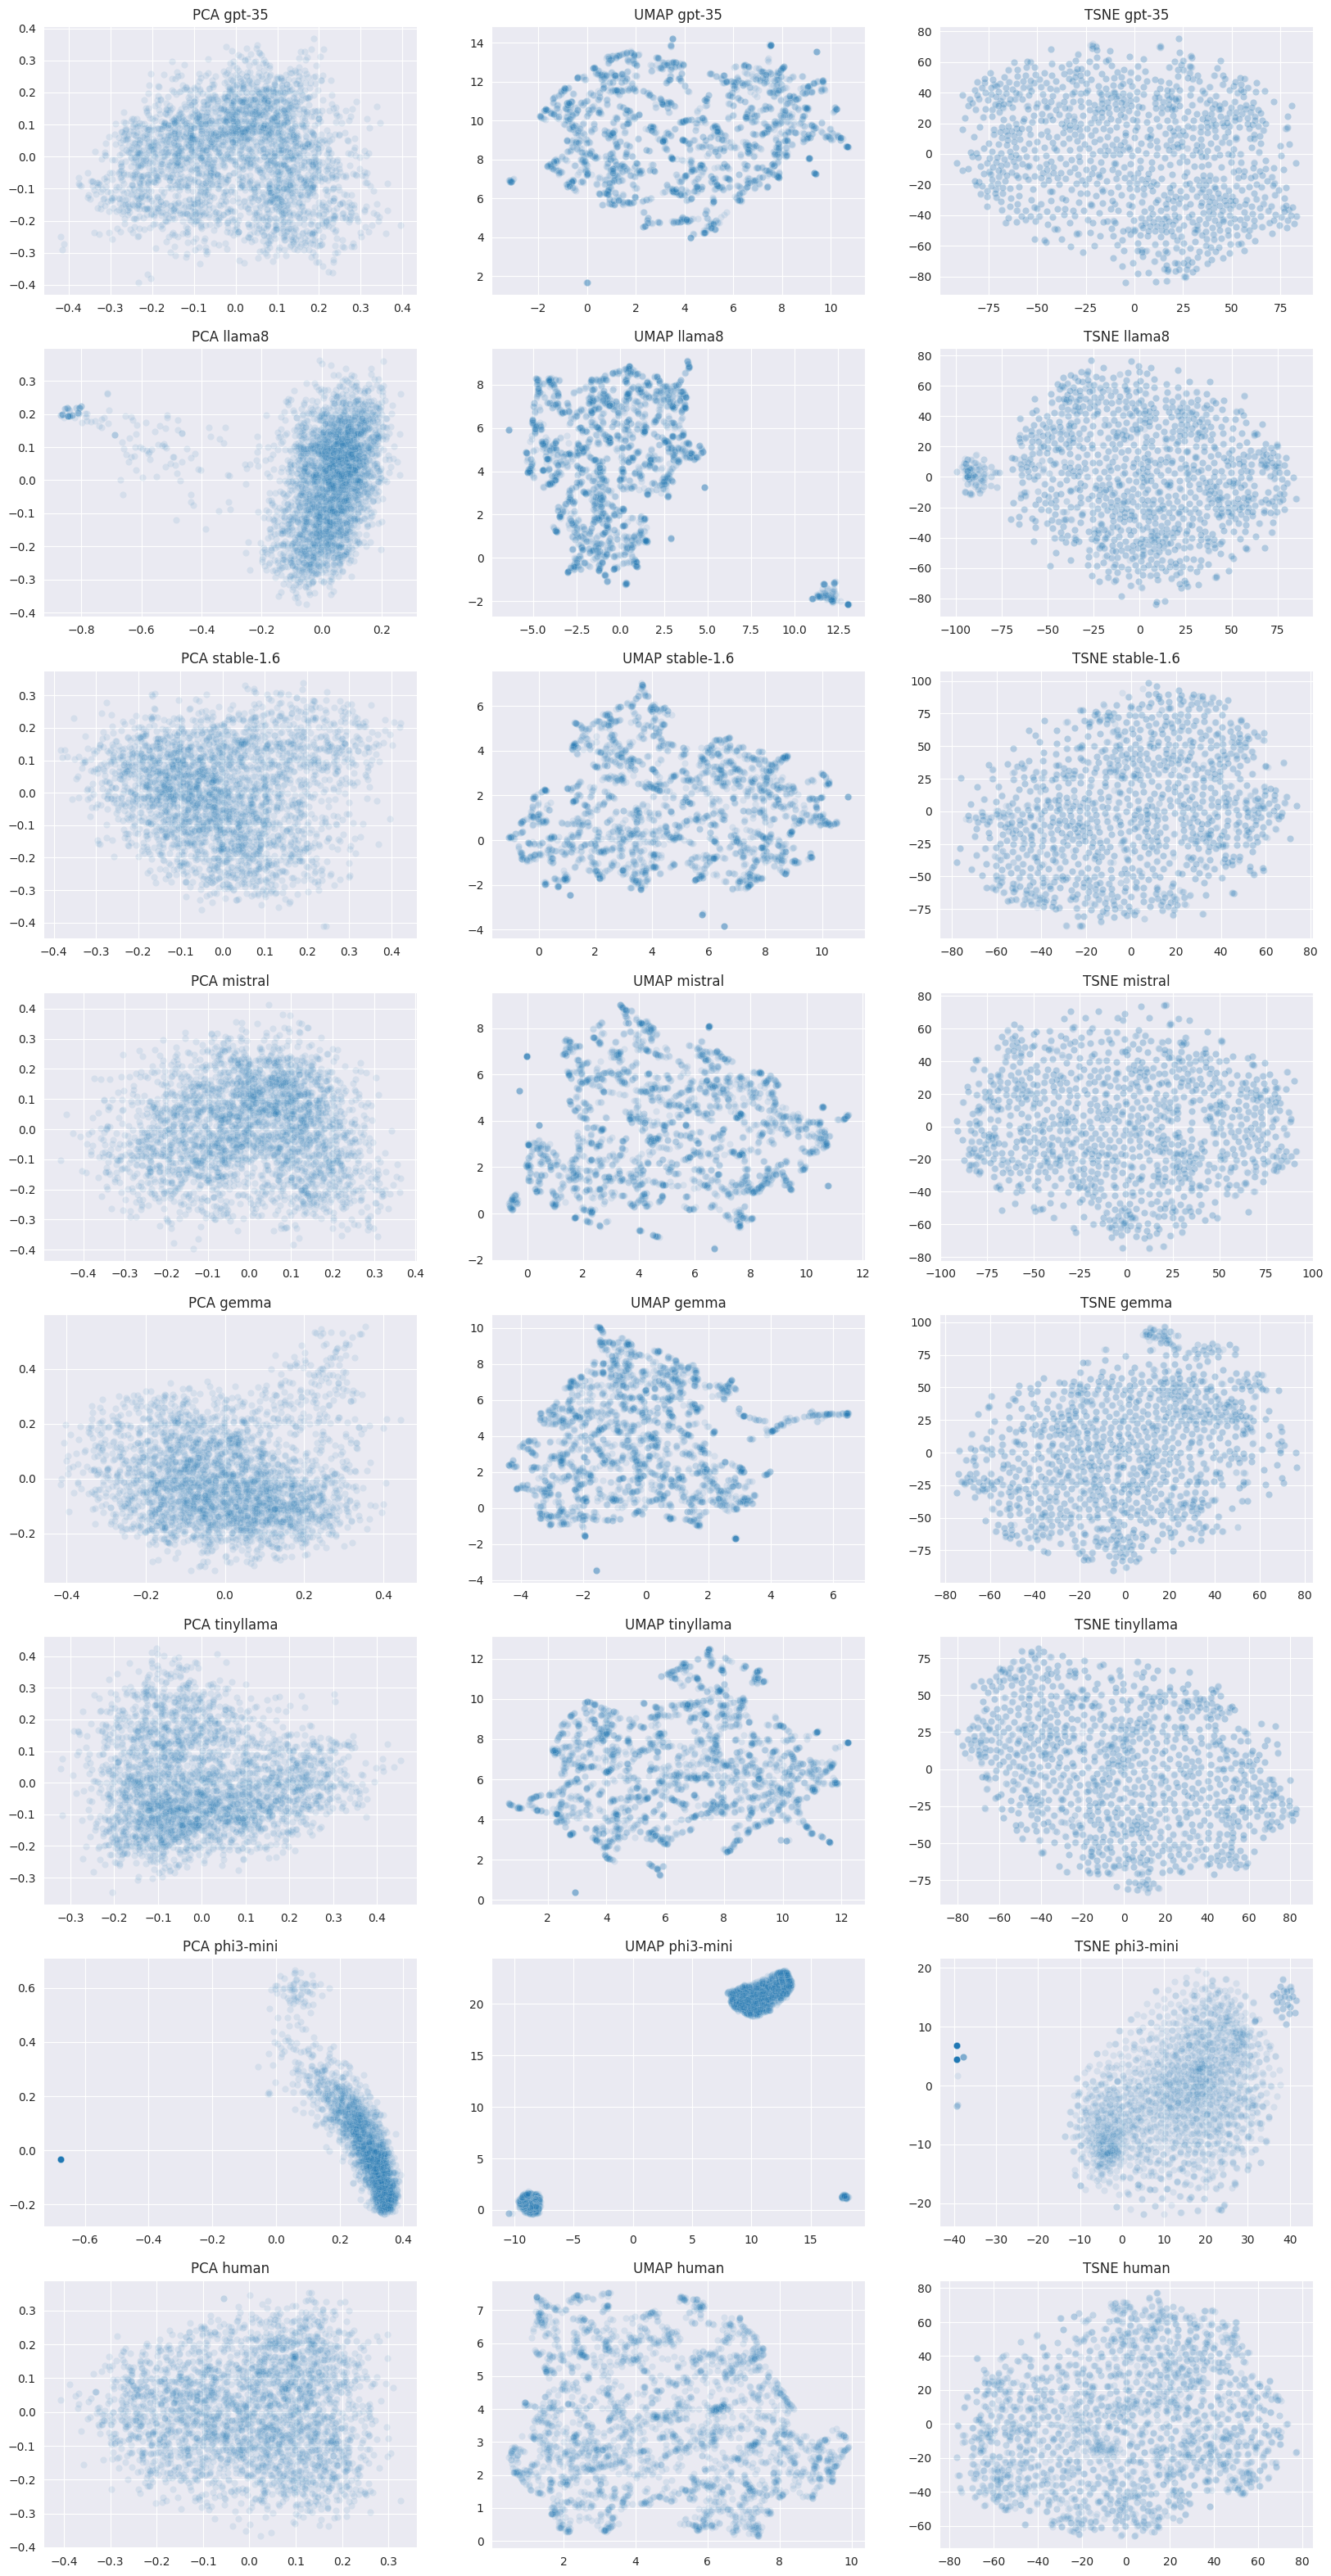

In [39]:
modes_count = len(replies_embeddings)
fig, axs = plt.subplots(modes_count, 3, figsize=(20, 40))
i = 0
for mode in replies_embeddings:
    print(f"Processing: {mode}")
    # flatten all the embedding
    flatten = [item for sublist in replies_embeddings[mode] for item in sublist]
    pca_chart(flatten, None, alpha=0.1, title=f"PCA {mode}", axis=axs[i, 0])
    umap_chart(flatten, None, alpha=0.1, title=f"UMAP {mode}", axis=axs[i, 1])
    tsne_chart(np.array(flatten), None, alpha=0.1, title=f"TSNE {mode}", axis=axs[i, 2])
    i += 1


In [40]:
import matplotlib.cm as cm
# now try to aggregate all the embeddings (but leaving the class) and see the distribution
# create a list with all the class for each embedding
all_classes = []
all_embeddings = []
for mode in replies_embeddings:
    for i in range(0, len(replies_embeddings[mode])):
        all_classes.extend([mode for _ in range(3)])
        all_embeddings.extend(replies_embeddings[mode][i])
    
len(all_classes), len(all_embeddings)

(24000, 24000)

In [41]:
# array of colors from the all_classes
colors = cm.rainbow(np.linspace(0, 1, len(replies_embeddings.keys())))
array_classes = list(replies_embeddings.keys())
def index_from_class(c):
    return array_classes.index(c)
color_classes = [colors[index_from_class(c)] for c in all_classes]


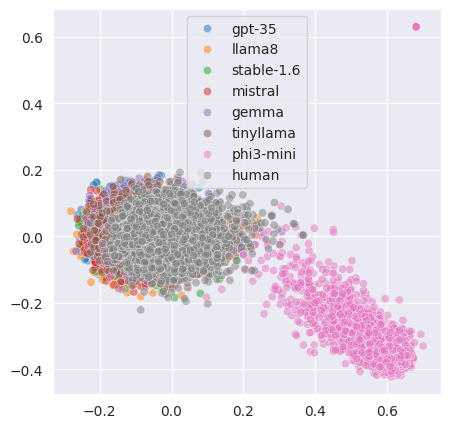

In [42]:
pca_chart(all_embeddings, where=None, alpha=0.5, size=5, labels=all_classes)

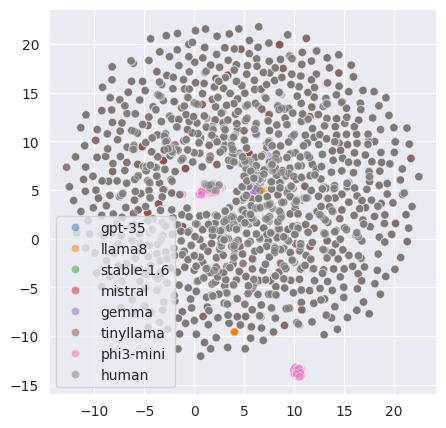

In [43]:
umap_chart(all_embeddings, where=None, alpha=0.5, size=5, labels=all_classes)

## Metrics analysis

In [44]:
# cosine distance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

In [100]:
how_many = 1000
all_distances = {}
for mode in replies_embeddings:
    print(f"Processing: {mode}")
    embeddings = replies_embeddings[mode]
    print(f"Embeddings: {how_many}")
    distances = []
    for i in range(0, how_many):
        distances.append(cosine_distances([embeddings[i][0]], [embeddings[i][1]])[0][0])
        distances.append(cosine_distances([embeddings[i][0]], [embeddings[i][2]])[0][0])
        distances.append(cosine_distances([embeddings[i][1]], [embeddings[i][2]])[0][0])
    print(f"Mean distance: {np.mean(distances)}")
    print(f"Median distance: {np.median(distances)}")
    print(f"Max distance: {np.max(distances)}")
    print(f"Min distance: {np.min(distances)}")
    print(f"Std distance: {np.std(distances)}")
    all_distances[mode] = distances

Processing: gpt-35
Embeddings: 1000
Mean distance: 0.09043355189011612
Median distance: 0.07927327438218473
Max distance: 0.9543229695241187
Min distance: 0.0
Std distance: 0.05729974455957574
Processing: llama8
Embeddings: 1000
Mean distance: 0.18715261102950334
Median distance: 0.15547200209533762
Max distance: 1.0003858886733525
Min distance: 0.0
Std distance: 0.13330843353229346
Processing: stable-1.6
Embeddings: 1000
Mean distance: 0.20861948198245966
Median distance: 0.18398999185784493
Max distance: 0.8715300693857482
Min distance: 0.04737018692457817
Std distance: 0.11003600664547046
Processing: mistral
Embeddings: 1000
Mean distance: 0.18144977820940586
Median distance: 0.171357788375124
Max distance: 0.5732064102107597
Min distance: 0.034363802919108344
Std distance: 0.06716338975326253
Processing: gemma
Embeddings: 1000
Mean distance: 0.19078486504630685
Median distance: 0.17571597937106265
Max distance: 0.8282311379492322
Min distance: 0.0
Std distance: 0.09815261936203681


<Axes: >

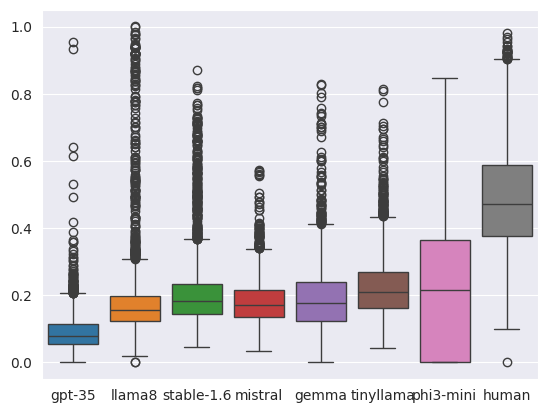

In [101]:
## boxplot of the distances
sns.boxplot(data=all_distances)

In [107]:
# measure the distance between the answer and the question
how_many = 1000
all_distances = {}
for mode in replies_embeddings:
    print(f"Processing: {mode}")
    embeddings = replies_embeddings[mode]
    print(f"Embeddings: {how_many}")
    distances = []
    for i in range(0, how_many):
        distances.append(cosine_similarity([question_embeddings[i]], [embeddings[i][0]])[0][0])
        distances.append(cosine_similarity([question_embeddings[i]], [embeddings[i][1]])[0][0])
        distances.append(cosine_similarity([question_embeddings[i]], [embeddings[i][2]])[0][0])
    print(f"Mean distance: {np.mean(distances)}")
    print(f"Median distance: {np.median(distances)}")
    print(f"Max distance: {np.max(distances)}")
    print(f"Min distance: {np.min(distances)}")
    print(f"Std distance: {np.std(distances)}")
    all_distances[mode] = distances

Processing: gpt-35
Embeddings: 1000
Mean distance: 0.7033784758021754
Median distance: 0.7112723546529869
Max distance: 0.8609526586501395
Min distance: 0.11424667168147826
Std distance: 0.06947408680330039
Processing: llama8
Embeddings: 1000
Mean distance: 0.6918666925155779
Median distance: 0.7146452531187804
Max distance: 0.8578453651983533
Min distance: 0.059313145220933436
Std distance: 0.11462794995648076
Processing: stable-1.6
Embeddings: 1000
Mean distance: 0.6977605442579294
Median distance: 0.7139963193181411
Max distance: 0.8490435468271158
Min distance: 0.1426569717403211
Std distance: 0.08523168381849881
Processing: mistral
Embeddings: 1000
Mean distance: 0.6634552005985
Median distance: 0.6697213477432564
Max distance: 0.8404534194205587
Min distance: 0.30244971264086806
Std distance: 0.0696378409015726
Processing: gemma
Embeddings: 1000
Mean distance: 0.6365473974101162
Median distance: 0.6464957530548749
Max distance: 0.8383533764177515
Min distance: 0.16300452184945505

<Axes: >

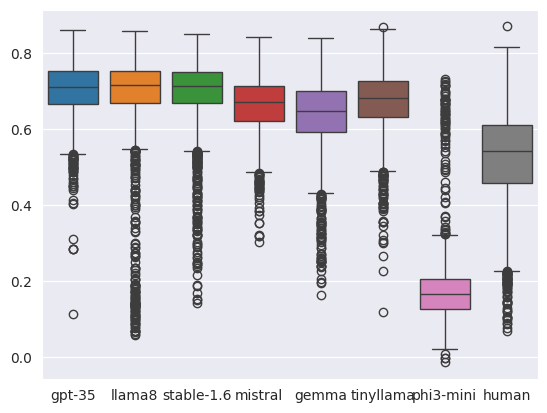

In [108]:
## boxplot of the distances
sns.boxplot(data=all_distances)

In [102]:
# combine the llm rensposes in just one element and the human in the other and measure the distance
how_many = 1000
all_distances = {}
llms = ["gpt-35", "llama8", "gemma", "mistral", "stable-1.6", "tinyllama"]
# combine the responses
combined_responses = []
for i in range(0, how_many):
    responses = []
    for llm in llms:
        responses.extend(replies_embeddings[llm][i])
    combined_responses.append(responses)

In [110]:
len(combined_responses)
# compute the consine distance for all the responses
collective = []
for i in range(0, how_many):
    for j in range(0, len(combined_responses[i])):
        for k in range(j+1, len(combined_responses[i])):
            collective.append(cosine_distances([combined_responses[i][j]], [combined_responses[i][k]])[0][0])
collective

[0.16317031575240315,
 0.14050391426406927,
 0.5128231727898398,
 0.20305435994850352,
 0.16571220196123282,
 0.40240929377554846,
 0.4067837060722024,
 0.42000792232568995,
 0.19468023074575025,
 0.1296339586183024,
 0.15489318414907927,
 0.3534044773581946,
 0.3169879139939449,
 0.35751940901592183,
 0.38569135282286826,
 0.37502146528732405,
 0.2986556440552729,
 0.0882289292244901,
 0.5480493720514943,
 0.2531300554939704,
 0.2762105086359099,
 0.3869055183766411,
 0.39004034789997843,
 0.39588908088114017,
 0.2581178761459215,
 0.24403674347818227,
 0.24661792933792204,
 0.4215279636819018,
 0.3887210740450695,
 0.4757592076960998,
 0.40900749370071143,
 0.39862350266598234,
 0.33860553937215476,
 0.5172229623305207,
 0.22896785541953124,
 0.23572517373813773,
 0.36740673588624184,
 0.3728988318272153,
 0.38069595865638384,
 0.23898644434456207,
 0.21952948451147858,
 0.20773575675943734,
 0.3812356963471,
 0.33865337707413723,
 0.4339387994803623,
 0.3740451361443562,
 0.36108363

In [111]:
elements = {
    "all": collective,
    "human": all_distances["human"]
}

In [113]:
print(f"Mean distance: {np.mean(collective)}")
print(f"Median distance: {np.median(collective)}")
print(f"Humans: {np.mean(all_distances['human'])}")
print(f"Humans: {np.median(all_distances['human'])}")

Mean distance: 0.26391991200784004
Median distance: 0.24203765574219727
Humans: 0.5248764812661483
Humans: 0.5420449499563694


<Axes: >

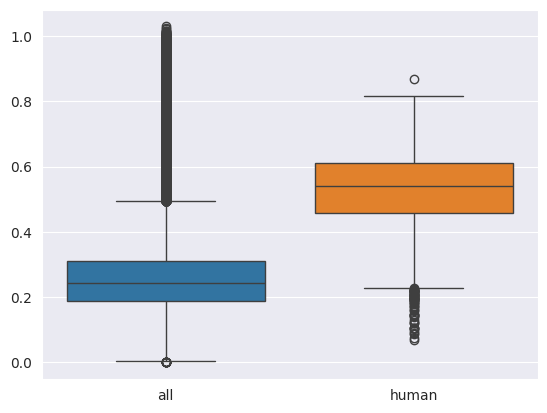

In [114]:
sns.boxplot(data=elements)

In [49]:
from datasets import Dataset 
from ragas.metrics import faithfulness
from ragas.metrics import answer_relevancy
from ragas import evaluate

In [50]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings

azure_configs = {
    "base_url": "https://pps-lab-fast.openai.azure.com/",
    "model_deployment": "gpt-35-fast",
    "model_name": "gpt-3.5-turbo",
    "embedding_deployment": "check-safety",
    "embedding_name": "text-embeddings-v1",  # most likely
}

In [53]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate

with open("secret/key.txt", "r") as f:
    os.environ["AZURE_OPENAI_API_KEY"] = f.read()
    
azure_model = AzureChatOpenAI(
    openai_api_version="2024-05-01-preview",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["model_deployment"],
    model=azure_configs["model_name"],
    validate_base_url=False,
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-05-01-preview",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["embedding_deployment"],
    model=azure_configs["embedding_name"],
)

In [56]:
from langchain_community.llms.ollama import Ollama
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

fast_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en")

data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'contexts' : [[''], ['']],
}
dataset = Dataset.from_dict(data_samples)
score = evaluate(dataset,metrics=[answer_relevancy], llm=azure_model, embeddings=fast_embeddings)
score.to_pandas()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

question  \
0  When was the first super bowl?   
1   Who won the most super bowls?   

                                              answer  \
0       The first superbowl was held on Jan 15, 1967   
1  The most super bowls have been won by The New ...   

                           contexts  answer_relevancy  
0  [When was the first super bowl?]               1.0  
1   [Who won the most super bowls?]               1.0

In [69]:
if os.path.exists("resources/metrics/results.pkl"):
    with open("resources/metrics/results.pkl", "rb") as f:
        results = pickle.load(f)
else:
    results = {}
restart = sampled.reset_index()
how_many = 1000
#results = {}
for mode in replies:
    print(f"Processing: {mode}")
    if(results.get(mode) is not None):
        print(f"Already done: {mode}")
        continue
    # create a dataset of the responses and the question
    # for each one, u should repeat the same question
    questions = restart.question.tolist()
    # repeat three times
    repeated_question = [questions[i] for i in range(0, how_many) for _ in range(3)]
    # flatten answers, from [[a,b,c], ... [c,b,d]] to [a,b,c,a,b,c]
    all_replies = []
    for i in range(0, how_many):
        all_replies.extend(replies[mode][i][1])
  
    contexts = [[""] for i in range(0, len(repeated_question))]
    data_samples = {
        'question': repeated_question,
        'answer': all_replies,
        'contexts' : contexts
    }
    dataset = Dataset.from_dict(data_samples)
    score = evaluate(dataset,metrics=[answer_relevancy], llm=azure_model, embeddings=fast_embeddings)
    results[mode] = score.to_pandas()
    print(score.to_pandas()["answer_relevancy"].mean())
    

Processing: gpt-35
Already done: gpt-35
Processing: llama8
Already done: llama8
Processing: stable-1.6
Already done: stable-1.6
Processing: mistral
Already done: mistral
Processing: gemma
Already done: gemma
Processing: tinyllama
Already done: tinyllama
Processing: phi3-mini
Already done: phi3-mini
Processing: human


Evaluating:   0%|          | 0/3000 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[712]: ValueError(Azure has not provided the response due to a content filter being triggered)
ERROR:ragas.executor:Exception raised in Job[367]: ValueError(Azure has not provided the response due to a content filter being triggered)
ERROR:ragas.executor:Exception raised in Job[1451]: TimeoutError()


0.6429003110726785


In [68]:
results["phi3-mini"] ={}

In [82]:
# store results
where = "resources/metrics/"
os.makedirs(os.path.dirname(where), exist_ok=True)
with open(where + "results.pkl", "wb") as f:
    pickle.dump(results, f)

question  \
0     Why do they circumcise women in Egypt , and wh...   
1     Why do they circumcise women in Egypt , and wh...   
2     Why do they circumcise women in Egypt , and wh...   
3     How does an Internal Combustion Engine work ? ...   
4     How does an Internal Combustion Engine work ? ...   
...                                                 ...   
2995  Why do clothes smell when not dried properly ?...   
2996  Why do clothes smell when not dried properly ?...   
2997  How do food companies determine the expiration...   
2998  How do food companies determine the expiration...   
2999  How do food companies determine the expiration...   

                                                 answer contexts  \
0     In ancient Egypt, both men and women were requ...       []   
1     In simple terms, let me explain!\n\nCircumcisi...       []   
2     In simple terms, when we talk about "circumcis...       []   
3     Sure! An internal combustion engine works by u...       []   
4     An internal combustion engine, also called a c...       []   
...                                                 ...      ...   
2995  When you wear clothes that aren't completely d...       []   
2996  When you wear clothes and they aren't complete...       []   
2997  Sure! Food companies use a special tool called...       []   
2998  Ah, I see you're curious about how food compan...       []   
2999  Ah, I understand! So when you saw the date on ...       []   

      answer_relevancy  
0             0.830922  
1             0.896421  
2             0.801298  
3             0.924077  
4             0.924077  
...                ...  
2995          0.917759  
2996          0.855425  
2997          0.741925  
2998          0.897959  
2999          0.816835  

[3000 rows x 4 columns]

In [80]:
# covert to dicts of mode => array of answer relevancy
results_dict = {}
for mode in results:
    results_dict[mode] = results[mode]["answer_relevancy"].tolist()

<Axes: >

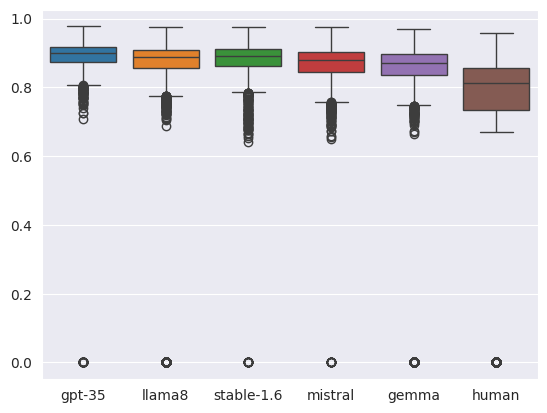

In [81]:
sns.boxplot(results_dict)